In [2]:
import random
from collections import Counter
import itertools
import math

import networkx as nx
import numpy as np
import pandas as pd
from scipy.special import softmax
from tqdm import trange, tqdm

In [3]:
class Car:
    def __init__(self, source, target) -> None:
        self.source = source
        self.target = target

    def __repr__(self) -> str:
        return f'<Car {self.source} -> {self.target}>'

    def act(self, network, verbose=False):
        if self.source == self.target or not nx.has_path(network, self.source, self.target):
            return self.source
        else:
            choices = list(nx.all_shortest_paths(network, self.source, self.target, weight='anticipated_latency'))
            choice = random.choice(choices)
            
            if verbose:
                print(f'Choose {choice} from {choices}.')
            
            return choice
            

class TrafficModel:
    def __init__(self, network, cars) -> None:
        self.network = network
        self.cars = cars

    def update_latencies(self):
        nx.set_edge_attributes(self.network, {(v, w): attr['latency_fn'](attr['utilization']) for v, w, attr in self.network.edges(data=True)}, 'latency')
        nx.set_edge_attributes(self.network, {(v, w): attr['latency_fn'](attr['utilization'] + (1 / len(self.cars))) for v, w, attr in self.network.edges(data=True)}, 'anticipated_latency')

    def update_latency(self, edge):
        self.network.edges[edge]['latency'] = self.network.edges[edge]['latency_fn'](self.network.edges[edge]['utilization'])
        self.network.edges[edge]['anticipated_latency'] = self.network.edges[edge]['latency_fn'](self.network.edges[edge]['utilization'] + (1 / len(self.cars)))

    @property
    def allowed_network(self):
        return nx.restricted_view(self.network, [], [(v, w) for v, w, allowed in self.network.edges(data='allowed') if not allowed])
    
    def decrease_utilization(self, edge):
        self.set_utilization(edge, self.network.edges[edge]['utilization'] - (1 / len(self.cars)))

    def increase_utilization(self, edge):
        self.set_utilization(edge, self.network.edges[edge]['utilization'] + (1 / len(self.cars)))

    def set_utilization(self, edge, utilization):
        self.network.edges[edge]['utilization'] = utilization
        self.update_latency(edge)

    def open_edge(self, edge):
        self.network.edges[edge]['allowed'] = True

    def close_edge(self, edge):
        self.network.edges[edge]['allowed'] = False

In [4]:
def run(model, number_of_steps, verbose=False):
    routes = {id: [] for id in model.cars}

    nx.set_edge_attributes(model.network, 0, 'utilization')
    model.update_latencies()

    stats = []
    for step in trange(number_of_steps):
        for id, car in np.random.permutation(list(model.cars.items())):
            for edge in zip(routes[id], routes[id][1:]):
                model.decrease_utilization(edge)

            # Let agents choose a route, given the network with allowed edges only
            routes[id] = car.act(model.allowed_network, verbose=verbose)

            for edge in zip(routes[id], routes[id][1:]):
                model.increase_utilization(edge)

        stats.append({
            **routes, 
            **nx.get_edge_attributes(model.network, 'latency'), 
            **{f'u({id})': nx.path_weight(model.network, route, 'latency') for id, route in routes.items()}})

    return pd.DataFrame(stats)

In [35]:
network = nx.DiGraph([('A', 0), ('A', 2), (0, 1), (0, 2), (0, 'B'), (1, 2), (1, 3), (2, 3), (2, 'B')])

# Latency is defined in terms of the utilization, i.e., the share of cars on a specific road
latency_fns = {
    ('A', 0): lambda u: 88 * u,
    ('A', 2): lambda u: 121,
    (0, 1): lambda u: 8 * u,
    (0, 2): lambda u: 11,
    (0, 'B'): lambda u: 121,
    (1, 2): lambda u: 1,
    (1, 3): lambda u: 11,
    (2, 3): lambda u: 8 * u,
    (2, 'B'): lambda u: 88 * u
}

nx.set_edge_attributes(network, latency_fns, 'latency_fn')

nx.set_edge_attributes(network, 0, 'utilization')
nx.set_edge_attributes(network, True, 'allowed')

number_of_cars = 10
cars = {id: Car('A', 'B') for id in range(number_of_cars)}

model = TrafficModel(network, cars)

In [36]:
model.close_edge((0, 2))
model.close_edge((1, 2))

stats = run(model, 3, verbose=True)

# Calculate social welfare as mean agent reward per step
stats['social_welfare'] = stats[[f'u({id})' for id in range(number_of_cars)]].mean(axis=1)

100%|██████████| 3/3 [00:00<00:00, 1254.90it/s]

Choose ['A', 2, 'B'] from [['A', 0, 'B'], ['A', 2, 'B']].
Choose ['A', 0, 'B'] from [['A', 0, 'B']].
Choose ['A', 0, 'B'] from [['A', 0, 'B'], ['A', 2, 'B']].
Choose ['A', 2, 'B'] from [['A', 2, 'B']].
Choose ['A', 0, 'B'] from [['A', 0, 'B'], ['A', 2, 'B']].
Choose ['A', 2, 'B'] from [['A', 2, 'B']].
Choose ['A', 2, 'B'] from [['A', 0, 'B'], ['A', 2, 'B']].
Choose ['A', 0, 'B'] from [['A', 0, 'B']].
Choose ['A', 0, 'B'] from [['A', 0, 'B'], ['A', 2, 'B']].
Choose ['A', 2, 'B'] from [['A', 2, 'B']].
Choose ['A', 2, 'B'] from [['A', 2, 'B']].
Choose ['A', 2, 'B'] from [['A', 2, 'B']].
Choose ['A', 0, 'B'] from [['A', 0, 'B']].
Choose ['A', 2, 'B'] from [['A', 2, 'B']].
Choose ['A', 0, 'B'] from [['A', 0, 'B']].
Choose ['A', 0, 'B'] from [['A', 0, 'B']].
Choose ['A', 0, 'B'] from [['A', 0, 'B']].
Choose ['A', 2, 'B'] from [['A', 2, 'B']].
Choose ['A', 0, 'B'] from [['A', 0, 'B']].
Choose ['A', 2, 'B'] from [['A', 2, 'B']].
Choose ['A', 0, 'B'] from [['A', 0, 'B']].
Choose ['A', 0, 'B'] f

<Axes: >

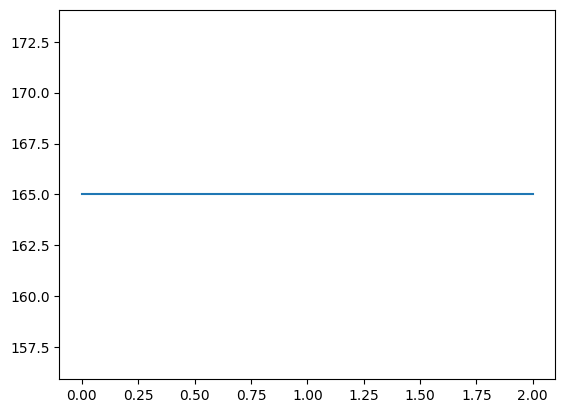

In [37]:
stats['social_welfare'].plot()

In [38]:
stats

,0,1,2,3,4,5,6,7,8,9,...,u(1),u(2),u(3),u(4),u(5),u(6),u(7),u(8),u(9),social_welfare
0,"[A, 2, B]","[A, 2, B]","[A, 0, B]","[A, 0, B]","[A, 2, B]","[A, 0, B]","[A, 2, B]","[A, 0, B]","[A, 0, B]","[A, 2, B]",...,165.0,165.0,165.0,165.0,165.0,165.0,165.0,165.0,165.0,165.0
1,"[A, 2, B]","[A, 2, B]","[A, 0, B]","[A, 0, B]","[A, 2, B]","[A, 0, B]","[A, 2, B]","[A, 0, B]","[A, 0, B]","[A, 2, B]",...,165.0,165.0,165.0,165.0,165.0,165.0,165.0,165.0,165.0,165.0
2,"[A, 2, B]","[A, 2, B]","[A, 0, B]","[A, 0, B]","[A, 2, B]","[A, 0, B]","[A, 2, B]","[A, 0, B]","[A, 0, B]","[A, 2, B]",...,165.0,165.0,165.0,165.0,165.0,165.0,165.0,165.0,165.0,165.0
